# Deep Q Learning to Play Space Invaders

In [1]:
# Import packages
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
import random
import time

from tensorflow.keras.models import Sequential
import tensorflow as tf
print(tf.__version__)

from skimage import transform 
from skimage.color import rgb2gray 

1.15.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7702164623993474524
]


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## [1] Create the environment

In [4]:
# Create our environment
env = gym.make("SpaceInvaders-v0")

# Get state and action space
state_size = env.observation_space
action_size = env.action_space.n

print("The size of our frame is: ", state_size)
print("The action size is : ", action_size)

The size of our frame is:  Box(210, 160, 3)
The action size is :  6


## [2] Preprocess Functions

In [5]:
# plotting the images in a list
def plot_frames(display_list, title_list = None):
    
    plt.figure(figsize=(10, 10))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1) 
        
        if title_list:
            plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')

    plt.show()

### [2.1] Image Filtering

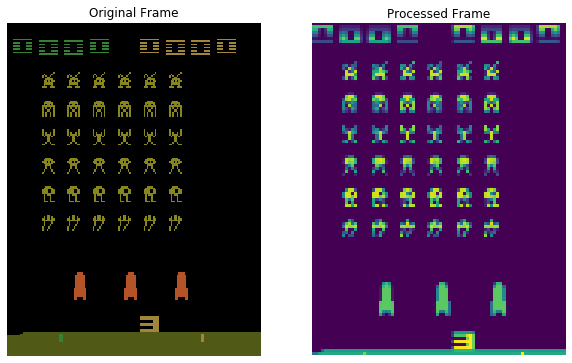

Size before process:  (210, 160, 3)
Size after process:  (110, 84)


In [6]:
# Normalise, turn into greyscale and crop image
frame_size = (110, 84)
def preprocess_frame(frame):
    # Greyscale frame 
    gray = rgb2gray(frame)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[8:-12,4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    # Thanks to Mikołaj Walkowiak
    preprocessed_frame = transform.resize(normalized_frame, frame_size)
    
    return preprocessed_frame # 110x84x1 frame

# Test out the preprocess procedure
sample_state = env.reset()
sample_state_processed = preprocess_frame(sample_state)
plot_frames([sample_state, sample_state_processed], ['Original Frame','Processed Frame'])

print('Size before process: ', sample_state.shape)
print('Size after process: ', sample_state_processed.shape)

### [2.2] Stack the frames

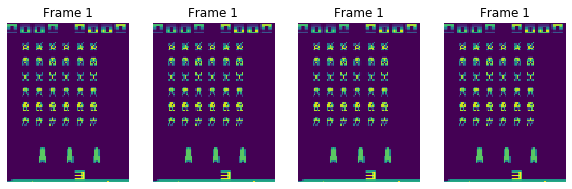

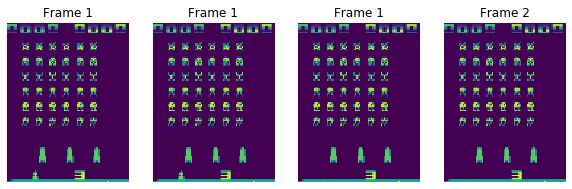

In [7]:
# Given a stacked frame, append a new frame to this stack
def stack_frames(stacked_frames, new_frame, is_new_episode):
    
    # Preprocess frame before stacking
    frame = preprocess_frame(new_frame)
    
    # if new episode make copies of frame, else append frame
    if is_new_episode:
        
        # Clear stacked frames
        stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)
        
        # Append the same frame to the stack stack_size times
        for _ in range(0, stack_size):
            stacked_frames.append(frame)
        
        # Return a numpy array for the stacked frame
        stacked_states = np.stack(stacked_frames, axis = 2)
    
    else:
        stacked_frames.append(frame)
        stacked_states = np.stack(stacked_frames, axis = 2)
    
    return stacked_states, stacked_frames

# Stacking frames to provide input = [frame 1, frame 2, frame 3, frame 4]
stack_size = 4

# Initialise with array of zeros
stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)

# Test out the stack_frames procedure
sample_state = env.reset()
stacked_states, stacked_frames = stack_frames(stacked_frames, sample_state, True)
plot_frames(stacked_frames, ['Frame ' + str(1) for i in range(0,4)])

for i in range(0, 4):
    sample_next_state, _ , done , _  = env.step(env.action_space.sample())
    stacked_states, stacked_frames = stack_frames(stacked_frames, sample_next_state, False)
    
plot_frames(stacked_frames, ['Frame ' + str(1) for i in range(1,4)] + ['Frame 2'] )

## 3 Training 

In [8]:
# Define paramters for training 
LEARNING_RATE = 0.001
MEMORY_SIZE = 50000
BATCH_SIZE = 64
MAX_STEP = 50000
UPDATE_MODEL_STEP = 5000

EXPLORATION_RATE = 1
EXPLORATION_DECAY = 0.9999
EXPLORATION_MIN = 0.01

GAMMA = 0.9

### [3.1] Create Deep Q Neural Network

In [9]:
class DQNetworks:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            """
            First convnet:
            CNN
            ELU
            """
            # Input is 110x84x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides = [4,4],
                                         padding = "VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")
            
            """
            Second convnet:
            CNN
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 64,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")

            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out")            
            
            """
            Third convnet:
            CNN
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 64,
                                 kernel_size = [3,3],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")

            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            self.flatten = tf.contrib.layers.flatten(self.conv3_out)
            
            ## Here to separate into two streams
            # The one to calculate V(s)
            self.value_fc = tf.layers.dense(inputs = self.flatten,
                                            units = 512,
                                            activation = tf.nn.elu,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            name="value_fc")
            
            self.value =  tf.layers.dense(inputs = self.value_fc,
                                          units = 1,
                                          activation = None,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          name="value")
            
            # The one to calculate A(s,a)
            self.advantage_fc = tf.layers.dense(inputs = self.flatten,
                                                units = 512,
                                                activation = tf.nn.elu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                                name="advantage_fc")
            
            self.advantage = tf.layers.dense(inputs = self.advantage_fc, 
                                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                             units = self.action_size, 
                                             activation=None,
                                             name = "advantage")
            
            
            # Agregating layer 
            self.output = tf.add(self.value, tf.subtract(self.advantage, tf.reduce_mean(self.advantage, axis=1, keepdims=True)))
              
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis = -1)
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

In [10]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetworks([110, 84, 4], action_size, LEARNING_RATE, "DQN")

# Instantiate the TargetDQNetwork
TargetDQNetwork = DQNetworks([110, 84, 4], action_size, LEARNING_RATE, "TargetDQN")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.


### [3.2] Create memory for experience relay

In [11]:
# Create a memery storage 
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

### [3.3] Act to exploit or explore

In [12]:
# Function to pick action either from model or take random action
def act(state, exploration_rate):
    
    # Take random action
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    
    # Else use the model to predict a action
    q_values = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state[tf.newaxis,...]})
    
    return np.argmax(q_values[0])

In [13]:
# Update the target network 
def update_graph():
    
    # Get weights
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "DQN")
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "TargetDQN")
    
    # Update the target 
    updated_weights = [to_var.assign(from_var) for from_var, to_var in zip(from_vars, to_vars)]
    
    return updated_weights

## [3.4] Train agent in batches from memory

In [14]:
# Function to fit data from experience obtained from memory, THE LEARNING PROCEDURE
def train_model(BATCH_SIZE):
    
    # Sample from batch
    batch = memory.sample(BATCH_SIZE)
    
    # Extract each parameter from batch
    state_batch = np.zeros((BATCH_SIZE, 110, 84, 4))
    action_batch = np.zeros([BATCH_SIZE, action_size], dtype = int)
    reward_batch = np.zeros(BATCH_SIZE)
    state_next_batch = np.zeros((BATCH_SIZE, 110, 84, 4))
    done_batch = np.zeros(BATCH_SIZE)
    for i in range(0,len(batch)):
        state_batch[i] = batch[i][0]
        action_batch[i][batch[i][1]] = 1
        reward_batch[i] = batch[i][2]
        state_next_batch[i] = batch[i][3]
        done_batch[i] = batch[i][4]

    # Model predict the Q-values
    Q_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state_next_batch})
    Target_Q_next_state = sess.run(TargetDQNetwork.output, feed_dict = {TargetDQNetwork.inputs_: state_next_batch})

    # Calculate target Q
    target_Q_batch = np.zeros(BATCH_SIZE)
    for i in range(0, len(batch)):
        if done_batch[i]:
            target_Q_batch[i] = reward_batch[i]
        else:
            best_action = np.argmax(Q_next_state[i])
            target_Q_batch[i] = reward_batch[i] + GAMMA * Target_Q_next_state[i][best_action]

    # Fit the data 
    loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                        feed_dict={DQNetwork.inputs_: state_batch,
                                                   DQNetwork.target_Q: target_Q_batch,
                                                   DQNetwork.actions_: action_batch})
    
    return loss

### [3.5] Test agent by taking random actions

In [16]:
# Play a game to test environment 
def test(n_episodes, model = None, memory = None):
    
    # Initialise average rewards
    avg_rewards = 0
    run_list = []
    
    for i in range(1, n_episodes+1):
        
        # Initialise the start of environment
        state = env.reset()
        stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        done = False 
        total_reward = 0
        steps = 0

        while not done:
            if model:
                action = np.argmax(model.predict(state[tf.newaxis,...])[0])
            else:
                action = env.action_space.sample()
            state_next, reward, done, info = env.step(action)
            state_next, stacked_frames = stack_frames(stacked_frames, state_next, False)
            if memory:
                memory.add((state, action, reward, state_next, done))
            state = state_next
            total_reward += reward
            steps += 1
            if steps > MAX_STEP:
                done = True
        
        avg_rewards = avg_rewards + 1/(i) * (total_reward - avg_rewards)
        run_list.append(steps)
        
    return run_list, avg_rewards


In [17]:
# Initialise memory
memory = Memory(MEMORY_SIZE)
steps, total_reward = test(1, model = None, memory = memory)

print("Total steps by taking random actions: ", steps)
print("Total rewards by taking random actions: ", total_reward)
print("Memory length: ", len(memory.buffer))

Total steps by taking random actions:  [805]
Total rewards by taking random actions:  120.0
Memory length:  805


In [19]:
# Define the training material
state_train = np.random.rand(2,110, 84, 4)
target_Q = np.random.rand(2)
action_list = np.array([[0,1,0,0,0,0], [0,0,0,0,1,0]])

with tf.Session() as sess:
    
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    
    Q_DQN = sess.run(DQNetwork.output, 
                                    feed_dict = {DQNetwork.inputs_: stacked_states[tf.newaxis,...]})[0]
    best_action = np.argmax(Q_DQN)
    
    Q_values = sess.run(TargetDQNetwork.output, 
                        feed_dict = {TargetDQNetwork.inputs_: stacked_states[tf.newaxis,...]})
    
    Q_update = Q_values[0][best_action]

print(Q_DQN)
print(best_action)
print(Q_values)
print(Q_update)

[-5.4348871e-04 -2.1732727e-04  6.0853607e-05  7.0980459e-05
  1.1606422e-04 -9.8547578e-05]
4
[[ 6.2244770e-04 -4.5187370e-04 -9.3657494e-05  5.6492392e-04
   2.4845303e-04 -7.5755343e-05]]
0.00024845303


In [ ]:
# Check time taken to train for 1 batch
start_time = time.time()
with tf.Session() as sess:
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    history = train_model(BATCH_SIZE)
print("Loss is :", history)
print("Elapsed_time: ", time.time() - start_time)

### Training on the environment

In [15]:
# Start the session
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())    

In [16]:
# Re-Initialise memory for training
memory = Memory(MEMORY_SIZE)

# Store measurements
loss = []
reward_list = []
step_list = []
total_steps = 0
start_time = time.time()
    
# Number of episodes to train 
N = 25  
for i in range(0, N):

    # Initialise state
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)
    reward_sum = 0

    # Initialise step oer episode
    step = 0
    done = False

    while not done:

        # Get action 
        action = act(state, EXPLORATION_RATE)

        # Take action
        state_next, reward, done, _ = env.step(action)

        # stops the episode by set max step
        if step > MAX_STEP:
            done = True
            print("Episode Done")

        # Append the next state
        state_next, stacked_frames = stack_frames(stacked_frames, state_next, False)

        # Append to memory
        memory.add((state, action, reward, state_next, done))

        # Forward to next state
        state = state_next

        # accumulate rewards
        reward_sum += reward

        # Update model every UPDATE_STEP (5000)
        if total_steps % UPDATE_MODEL_STEP == 0:
            sess.run(update_graph())
            print("Target network updated!")

        # accumilate steps
        step += 1
        total_steps += 1

        # Reduce the exploreation every step
        EXPLORATION_RATE *= EXPLORATION_DECAY
        EXPLORATION_RATE = max(EXPLORATION_MIN, EXPLORATION_RATE)

        ### Learning procedure begins ###
        # learn only when memory has be filled to batch size
        if len(memory.buffer) > BATCH_SIZE:
            history = train_model(BATCH_SIZE)

            # store loss
            loss.append(history)
        ### Learning procedure ends ###

        # Print messge every 100 episodes
        if total_steps % 100 == 0:
            print("Afte {} steps, exploration rate: {:.4f}, reward: {}, Model loss: {:.4f}"\
                  .format(total_steps, EXPLORATION_RATE, reward_sum, history))


    # Append values at the end of an episode
    step_list.append(step)
    reward_list.append(reward_sum)

    # print information at the end of the episode
    print("Episode {}, exploration rate: {:.4f}, final rewards: {}, final loss is {:.4f}, Time elapsed: {:.4f}"\
          .format(i+1, EXPLORATION_RATE, reward_sum, history, time.time() - start_time))
    start_time = time.time()

save_path = saver.save(sess, "./D3QN_models/model.ckpt")
print("Model Saved")

Target network updated!
Afte 100 steps, exploration rate: 0.9900, reward: 5.0, Model loss: 0.0167
Afte 200 steps, exploration rate: 0.9802, reward: 65.0, Model loss: 5.9358
Afte 300 steps, exploration rate: 0.9704, reward: 65.0, Model loss: 0.4110
Afte 400 steps, exploration rate: 0.9608, reward: 65.0, Model loss: 0.2698
Afte 500 steps, exploration rate: 0.9512, reward: 110.0, Model loss: 0.4748
Afte 600 steps, exploration rate: 0.9418, reward: 110.0, Model loss: 0.7594
Episode 1, exploration rate: 0.9381, final rewards: 110.0, final loss is 1.5471, Time elapsed: 78.5206
Afte 700 steps, exploration rate: 0.9324, reward: 0.0, Model loss: 0.3748
Afte 800 steps, exploration rate: 0.9231, reward: 30.0, Model loss: 0.5959
Afte 900 steps, exploration rate: 0.9139, reward: 60.0, Model loss: 0.1604
Afte 1000 steps, exploration rate: 0.9048, reward: 80.0, Model loss: 0.4934
Afte 1100 steps, exploration rate: 0.8958, reward: 105.0, Model loss: 0.2518
Episode 2, exploration rate: 0.8896, final re

KeyboardInterrupt: 

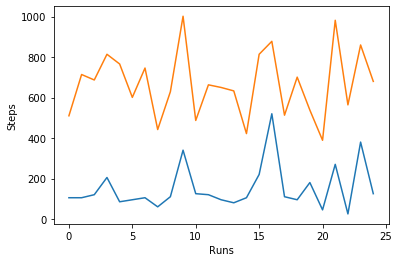

In [16]:
# plot result
plt.plot(reward_list)
plt.ylabel('Steps')
plt.xlabel('Runs')


plt.plot(step_list)
plt.ylabel('Steps')
plt.xlabel('Runs')

plt.show()

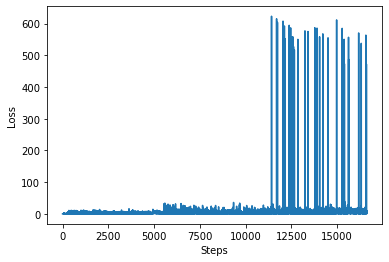

In [17]:
# plot loss
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.show()

In [18]:
# Number of steps learnt
len(memory.buffer)

16685

In [17]:
# simulate a result play a game and render

# Load the model
saver.restore(sess, "./D3QN_models/model.ckpt")

# Initialise environment 
state = env.reset()
state, stacked_frames = stack_frames(stacked_frames, state, True)

done = False 
total_reward = 0
steps = 0

# Until done 
while not done:

    # render the current environment 
    env.render()

    # take an action using model
    Q_values= sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state[tf.newaxis,...]})
    action = np.argmax(Q_values[0])
    next_state, reward, done, info = env.step(action)
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
    state = next_state

    total_reward += reward
    steps += 1

    # pause for visualisation
    time.sleep(0.01)

env.close()
print ("Score: {}, Steps: {}".format(total_reward, steps))

Score: 145.0, Steps: 640
